In [79]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns


In [80]:
ratings = pd.read_csv("../data/cleaned_data/ratings_clean.csv")
movies = pd.read_csv("../data/cleaned_data/movies_clean.csv")

**Constructing User Taste Features**

In [81]:
user_features = (
    ratings
    .groupby('userId')
    .agg(
        mean_rating=('rating', 'mean'),
        rating_std=('rating', 'std'),
        num_ratings=('rating', 'count')
    )
    .fillna(0)
)

user_features['log_num_ratings'] = np.log1p(user_features['num_ratings'])
user_features.head()

,mean_rating,rating_std,num_ratings,log_num_ratings
userId,,,,
1,3.742857,0.382284,175,5.170484
2,4.000000,1.064581,61,4.127134
3,4.122995,0.910427,187,5.236442
4,3.571429,0.790151,28,3.367296
5,4.272727,0.969464,66,4.204693


**These features capture generosity, consistency, and engagement intensity — core dimensions of user taste.**


**FEATURE SCALING**

In [82]:
scaler = StandardScaler()
X = scaler.fit_transform(
    user_features[['mean_rating', 'rating_std', 'log_num_ratings']]
)

**Choosing Number of Tribes**

In [83]:
sil_scores = {}

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    sil_scores[k] = silhouette_score(X, labels)

pd.Series(sil_scores)


2    0.274527
3    0.288876
4    0.242853
5    0.231541
6    0.247943
7    0.239596
dtype: float64

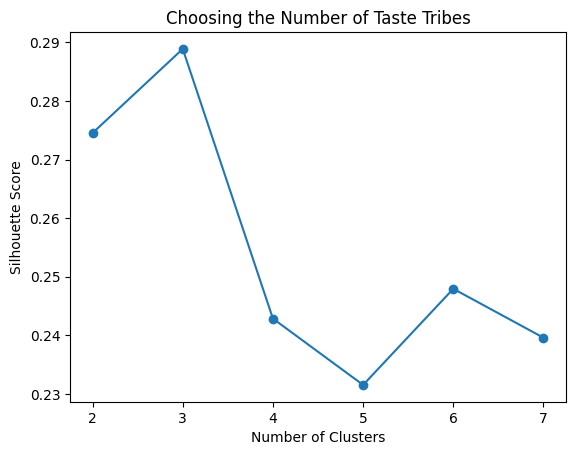

In [84]:
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Choosing the Number of Taste Tribes")
plt.show()

**BASED ON SILHOUTTE SCORES,I'LL PROCEED WITH K = 3**

In [85]:
kmeans = KMeans(n_clusters=3, random_state=42)
user_features['tribe'] = kmeans.fit_predict(X)

In [86]:
tribe_summary = (
    user_features
    .groupby('tribe')
    .agg(
        users=('mean_rating', 'count'),
        avg_rating=('mean_rating', 'mean'),
        avg_variance=('rating_std', 'mean'),
        avg_activity=('num_ratings', 'mean')
    )
)

tribe_summary

,users,avg_rating,avg_variance,avg_activity
tribe,,,,
0,63153,3.893834,0.826259,59.517917
1,38499,3.527965,0.912879,362.859685
2,36841,3.273869,1.210860,61.664803


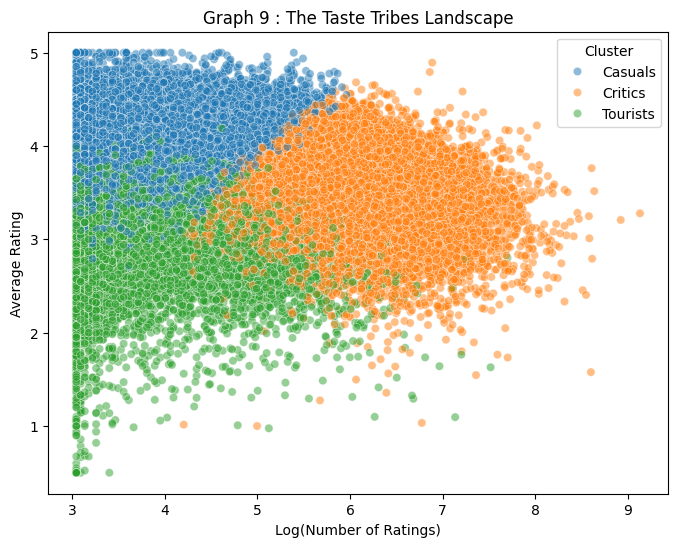

In [87]:
plt.figure(figsize=(8,6))
tribe_labels = user_features['tribe'].map({0: 'Casuals', 1: 'Critics', 2: 'Tourists'})
sns.scatterplot(
    x=user_features['log_num_ratings'],
    y=user_features['mean_rating'],
    hue=tribe_labels,
    palette='tab10',
    alpha=0.5
)
plt.xlabel("Log(Number of Ratings)")
plt.ylabel("Average Rating")
plt.title("Graph 9 : The Taste Tribes Landscape")
plt.legend(title='Cluster')
plt.show()


Based on observed behavior patterns, the tribes can be interpreted as:

- **Toursists** – low activity,low ratings
- **The Critics** – high activity, low average ratings  
- **The Casuals** – low activity, high ratings  

In [88]:
ratings_with_tribes = ratings.merge(
    user_features[['tribe']],
    left_on='userId',
    right_index=True
)

tribe_movie_stats = (
    ratings_with_tribes
    .groupby(['tribe', 'movieId'])
    .agg(
        avg_rating=('rating', 'mean'),
        rating_count=('rating', 'count')
    )
    .reset_index()
)

tribe_movie_stats = tribe_movie_stats[tribe_movie_stats['rating_count'] > 50]


In [89]:
def top_bottom(df, tribe, top=True, n=10):
    subset = df[df['tribe'] == tribe]
    subset = subset.sort_values('avg_rating', ascending=not top).head(n)
    return subset.merge(movies[['movieId', 'title']], on='movieId')

top_bottom(tribe_movie_stats, tribe=0, top=True)


,tribe,movieId,avg_rating,rating_count,title
0,0,93040,4.658730,63,"Civil War, The (1990)"
1,0,670,4.581081,185,"World of Apu, The (Apur Sansar) (1959)"
2,0,318,4.563986,25654,"Shawshank Redemption, The (1994)"
3,0,77658,4.547945,292,Cosmos (1980)
4,0,7089,4.543103,58,Amarcord (1973)
5,0,26150,4.537037,108,Andrei Rublev (Andrey Rublyov) (1969)
6,0,2609,4.534722,72,"King of Masks, The (Bian Lian) (1996)"
7,0,7926,4.511765,85,High and Low (Tengoku to jigoku) (1963)
8,0,2905,4.511299,177,Sanjuro (Tsubaki Sanjûrô) (1962)
9,0,858,4.505720,14074,"Godfather, The (1972)"


The Taste Tribes analysis shows that MovieLens users do not form a single homogeneous audience. 
Instead, engagement patterns reveal multiple, stable viewing personas that coexist across the platform’s lifespan.


In [90]:
movies_genre = pd.read_csv("../data/cleaned_data/movies_clean.csv")

In [91]:
ratings_with_genres = ratings.merge(
    movies_genre[['movieId', 'genres']],
    on='movieId',
    how='inner'
)

ratings_with_genres.head()


,userId,movieId,rating,timestamp,rating_year,rating_month,genres
0,1,2,3.5,2005-04-02 23:53:47,2005,2005-04,Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,2005,2005-04,Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,2005,2005-04,Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,2005,2005-04,Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,2005,2005-04,Crime|Mystery|Thriller


In [92]:
global_genre_mean = (
    ratings_with_genres
    .groupby('genres')['rating']
    .mean()
    .rename('global_mean')
)

In [93]:
cluster_names = {
    0: "Casuals",
    1: "Critics",
    2: "Tourists"
}



In [ ]:
movies_genre_exploded = pd.read_csv("../data/cleaned_data/movies_genres_clean.csv")

ratings_with_tribes_genres = ratings.merge(
    user_features[['tribe']],
    left_on='userId',
    right_index=True
).merge(
    movies_genre_exploded[['movieId', 'genre_list']],
    on='movieId',
    how='inner'
)

genre_preferences = (
    ratings_with_tribes_genres
    .groupby(['tribe', 'genre_list'])['rating']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'avg_rating', 'count': 'num_ratings', 'genre_list': 'genre'})
)

genre_preferences = genre_preferences[genre_preferences['num_ratings'] >= 100]

global_genre_mean = (
    ratings_with_tribes_genres
    .groupby('genre_list')['rating']
    .mean()
    .rename_axis('genre')
    .rename('global_mean')
)

genre_preferences = genre_preferences.merge(
    global_genre_mean.reset_index(),
    on='genre',
    how='left'
)
genre_preferences['preference_delta'] = genre_preferences['avg_rating'] - genre_preferences['global_mean']

print("Genre Preferences by Cluster (sorted by preference deviation):\n")
for tribe_id in [0, 1, 2]:
    print(f" {cluster_names[tribe_id].upper()}")
    
    tribe_prefs = genre_preferences[genre_preferences['tribe'] == tribe_id].copy()
    tribe_prefs = tribe_prefs.sort_values('preference_delta', ascending=False)
    
    print(f"\n TOP LIKED GENRES (vs global average):")
    for idx, row in tribe_prefs.head(5).iterrows():
        print(f"   {row['genre']:25s} | Avg: {row['avg_rating']:.2f} | +{row['preference_delta']:.3f} | ({int(row['num_ratings'])} ratings)")
    
    print(f"\n LEAST LIKED GENRES (vs global average):")
    for idx, row in tribe_prefs.tail(5).iterrows():
        print(f"   {row['genre']:25s} | Avg: {row['avg_rating']:.2f} | {row['preference_delta']:.3f} | ({int(row['num_ratings'])} ratings)")


Genre Preferences by Cluster (sorted by preference deviation):

 CASUALS

 TOP LIKED GENRES (vs global average):
   Horror                    | Avg: 3.83 | +0.551 | (210621 ratings)
   Children                  | Avg: 3.86 | +0.448 | (333895 ratings)
   Sci-Fi                    | Avg: 3.88 | +0.445 | (601730 ratings)
   Action                    | Avg: 3.88 | +0.434 | (1121467 ratings)
   Fantasy                   | Avg: 3.93 | +0.427 | (400666 ratings)

 LEAST LIKED GENRES (vs global average):
   Animation                 | Avg: 3.99 | 0.372 | (238004 ratings)
   Crime                     | Avg: 4.05 | 0.371 | (683119 ratings)
   Musical                   | Avg: 3.92 | 0.365 | (167343 ratings)
   Western                   | Avg: 3.91 | 0.339 | (84368 ratings)
   Film-Noir                 | Avg: 4.25 | 0.283 | (40721 ratings)
 CRITICS

 TOP LIKED GENRES (vs global average):
   Documentary               | Avg: 3.72 | +-0.024 | (193645 ratings)
   Western                   | Avg: 3.54 |

## Top & Bottom Movies by Cluster

In [95]:
tribe_movie_stats_detailed = (
    ratings_with_tribes_genres
    .groupby(['tribe', 'movieId'])
    .agg(
        avg_rating=('rating', 'mean'),
        rating_count=('rating', 'count')
    )
    .reset_index()
    .merge(movies[['movieId', 'title']], on='movieId')
)

tribe_movie_stats_detailed = tribe_movie_stats_detailed[tribe_movie_stats_detailed['rating_count'] >= 50]

print("TOP & BOTTOM 5 MOVIES BY CLUSTER: ")

for tribe_id in [0, 1, 2]:
    print(f" {cluster_names[tribe_id].upper()}")
    
    tribe_movies = tribe_movie_stats_detailed[tribe_movie_stats_detailed['tribe'] == tribe_id].copy()
    
    print(f"\n TOP 5 MOVIES (Loved by {cluster_names[tribe_id]}):")
    top_movies = tribe_movies.nlargest(5, 'avg_rating')
    for idx, (_, row) in enumerate(top_movies.iterrows(), 1):
        print(f"   {idx}. [{row['avg_rating']:.2f}] {row['title'][:60]:60s} ({int(row['rating_count'])} ratings)")
    
    print(f"\n BOTTOM 5 MOVIES (Disliked by {cluster_names[tribe_id]}):")
    bottom_movies = tribe_movies.nsmallest(5, 'avg_rating')
    for idx, (_, row) in enumerate(bottom_movies.iterrows(), 1):
        print(f"   {idx}. [{row['avg_rating']:.2f}] {row['title'][:60]:60s} ({int(row['rating_count'])} ratings)")


TOP & BOTTOM 5 MOVIES BY CLUSTER: 
 CASUALS

 TOP 5 MOVIES (Loved by Casuals):
   1. [4.71] Heart of a Dog (Sobachye serdtse) (1988)                     (57 ratings)
   2. [4.66] Civil War, The (1990)                                        (126 ratings)
   3. [4.61] Matter of Life and Death, A (Stairway to Heaven) (1946)      (99 ratings)
   4. [4.61] Mind Game (2004)                                             (114 ratings)
   5. [4.58] Come and See (Idi i smotri) (1985)                           (86 ratings)

 BOTTOM 5 MOVIES (Disliked by Casuals):
   1. [1.34] From Justin to Kelly (2003)                                  (58 ratings)
   2. [1.43] Glitter (2001)                                               (129 ratings)
   3. [1.56] Son of the Mask (2005)                                       (128 ratings)
   4. [1.59] Gigli (2003)                                                 (111 ratings)
   5. [1.68] Disaster Movie (2008)                                        (56 ratings)
 CRIT

## Visual: Genre Preferences Heatmap

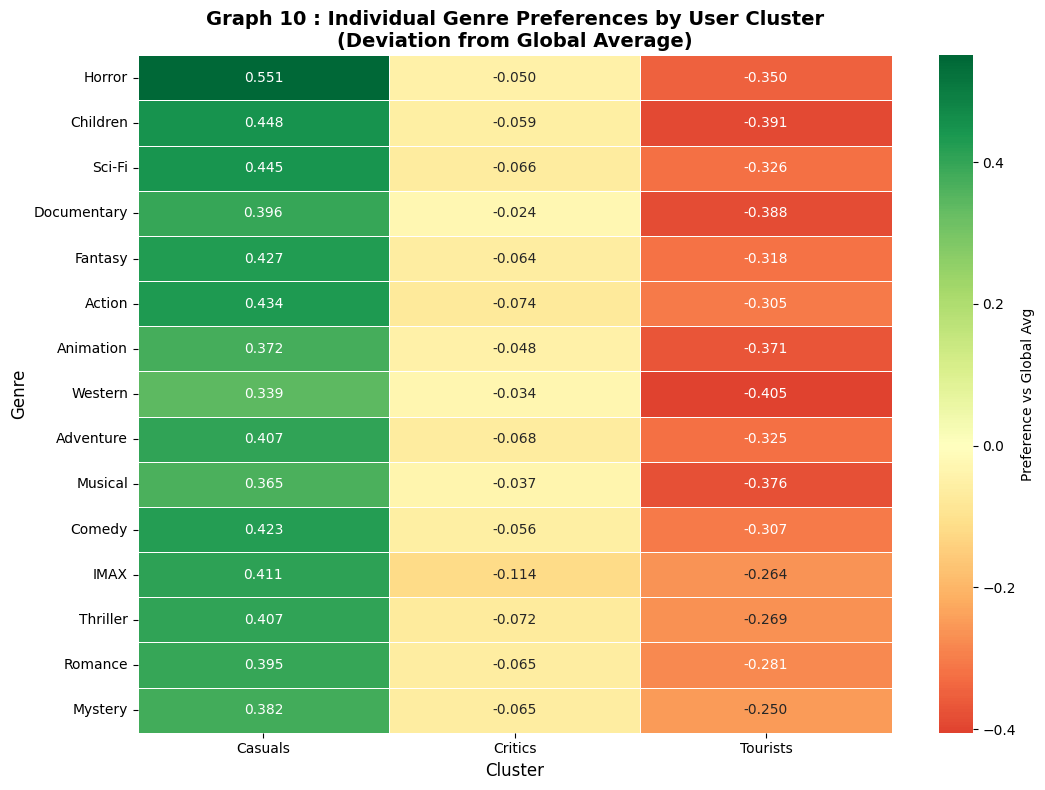

Green (positive) = Cluster rates this genre higher than average
 Red (negative) = Cluster rates this genre lower than average


In [100]:
genre_pref_pivot = genre_preferences.pivot_table(
    index='genre',
    columns='tribe',
    values='preference_delta',
    aggfunc='first'
)

genre_pref_pivot['variance'] = genre_pref_pivot.std(axis=1)
genre_pref_pivot = genre_pref_pivot.sort_values('variance', ascending=False).head(15)
genre_pref_pivot = genre_pref_pivot.drop('variance', axis=1)

genre_pref_pivot.columns = [cluster_names[col] for col in genre_pref_pivot.columns]

fig, ax = plt.subplots(figsize=(11, 8))
sns.heatmap(
    genre_pref_pivot,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    center=0,
    cbar_kws={'label': 'Preference vs Global Avg'},
    ax=ax,
    linewidths=0.5
)
ax.set_title('Graph 10 : Individual Genre Preferences by User Cluster\n(Deviation from Global Average)', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

print("Green (positive) = Cluster rates this genre higher than average")
print(" Red (negative) = Cluster rates this genre lower than average")


## Cluster vs Global Average Ratings by Genre

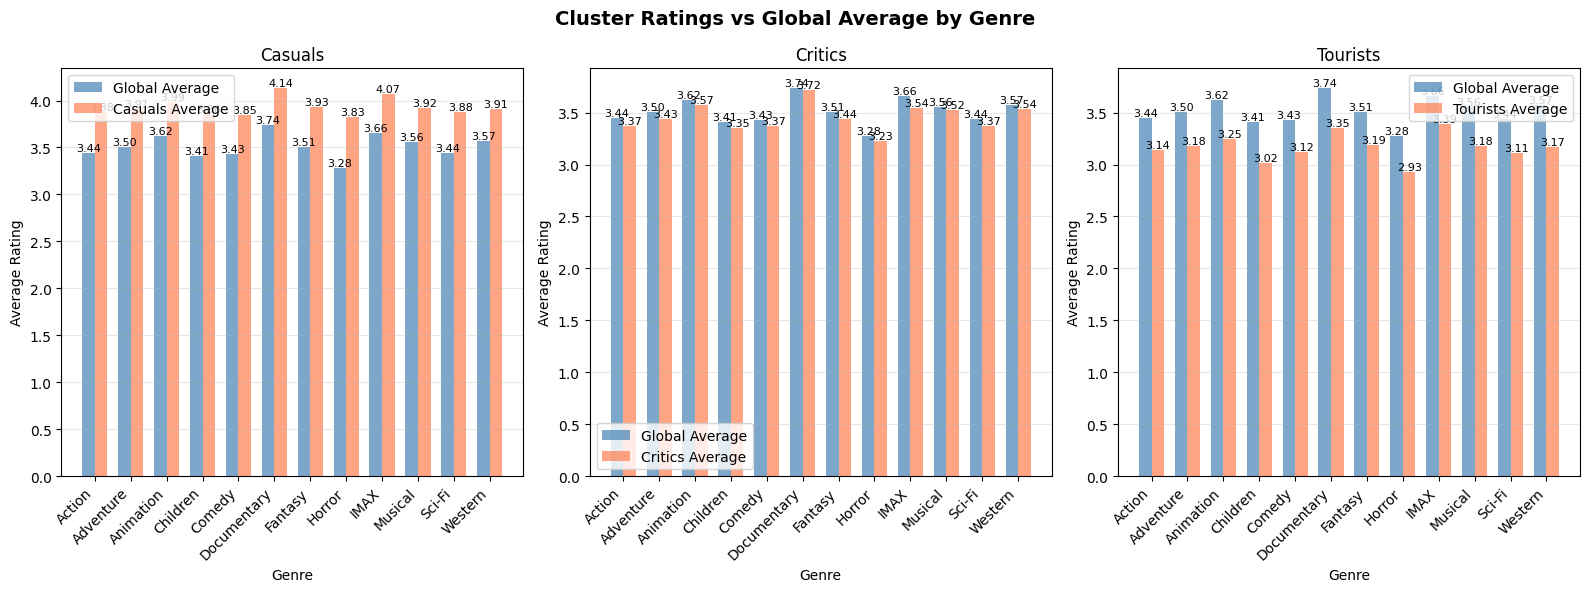


💡 Interpretation:
   • Blue bars = Global average (how ALL users rate each genre)
   • Orange bars = This cluster's average (how THIS cluster rates each genre)
   • When orange > blue: Cluster LOVES that genre more than average
   • When orange < blue: Cluster DISLIKES that genre more than average


In [ ]:
genre_comparison = genre_preferences.copy()
genre_comparison['cluster_name'] = genre_comparison['tribe'].map(cluster_names)

top_genres = genre_preferences.groupby('genre')['avg_rating'].std().nlargest(12).index.tolist()
genre_comparison_filtered = genre_comparison[genre_comparison['genre'].isin(top_genres)]

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Cluster Ratings vs Global Average by Genre', fontsize=14, fontweight='bold')

for idx, tribe_id in enumerate([0, 1, 2]):
    ax = axes[idx]
    
    cluster_data = genre_comparison_filtered[genre_comparison_filtered['tribe'] == tribe_id].sort_values('genre')
    
    x = np.arange(len(cluster_data))
    width = 0.35
    
    global_avgs = []
    for genre in cluster_data['genre'].values:
        global_avg = cluster_data[cluster_data['genre'] == genre]['global_mean'].values[0]
        global_avgs.append(global_avg)
    
    bars1 = ax.bar(x - width/2, global_avgs, width, label='Global Average', alpha=0.7, color='steelblue')
    bars2 = ax.bar(x + width/2, cluster_data['avg_rating'].values, width, label=f'{cluster_names[tribe_id]} Average', alpha=0.7, color='coral')
    
    ax.set_xlabel('Genre')
    ax.set_ylabel('Average Rating')
    ax.set_title(f'{cluster_names[tribe_id]}')
    ax.set_xticks(x)
    ax.set_xticklabels(cluster_data['genre'].values, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n Interpretation:")
print("   • Blue bars = Global average (how ALL users rate each genre)")
print("   • Orange bars = This cluster's average (how THIS cluster rates each genre)")
print("   • When orange > blue: Cluster LOVES that genre more than average")
print("   • When orange < blue: Cluster DISLIKES that genre more than average")


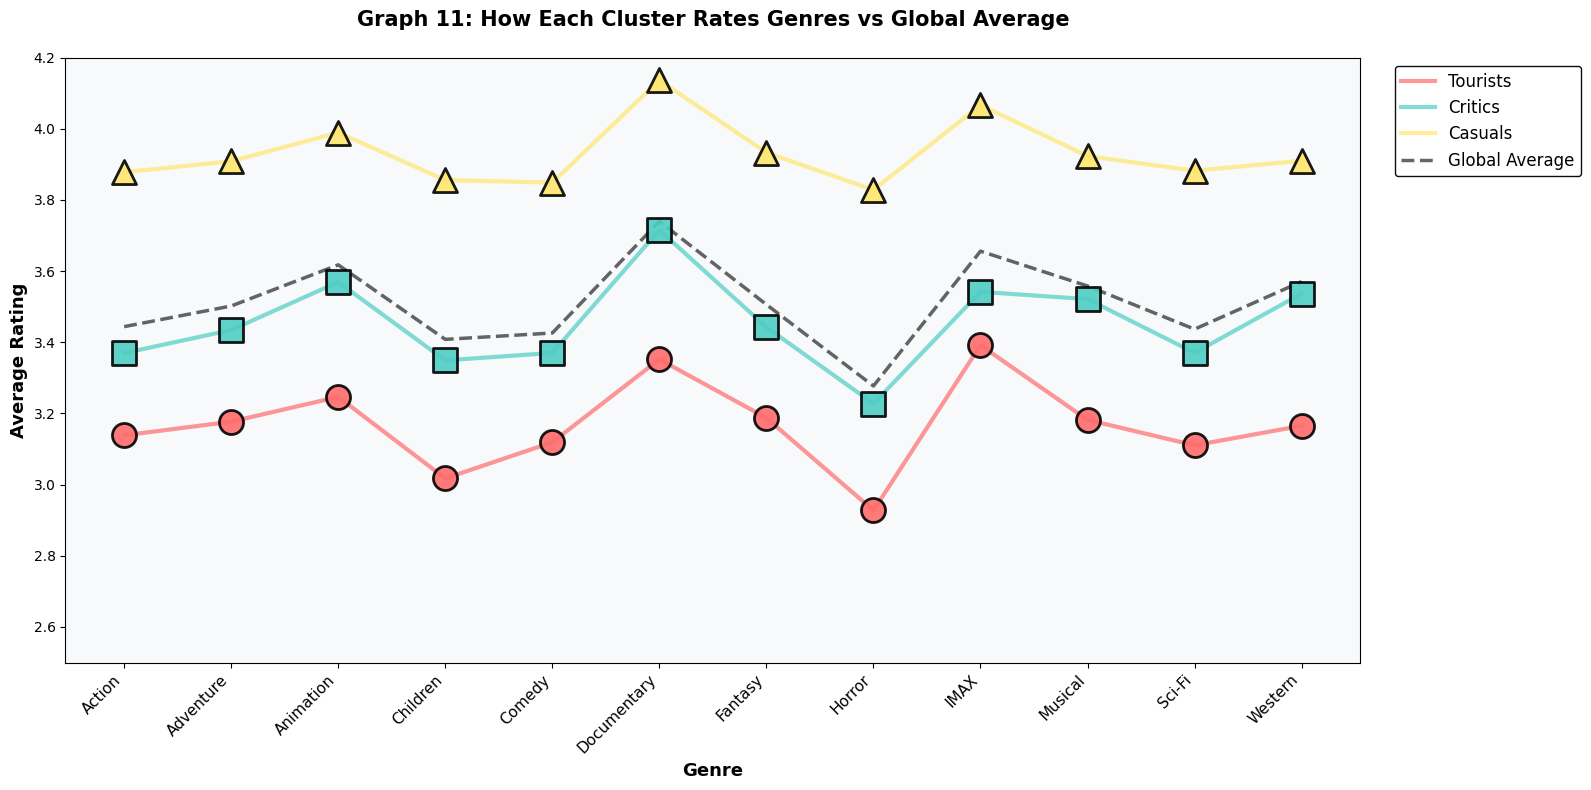

INTERPRETATION
Each line represents how a cluster rates all genres:
Tourists (Red Circles)
Critics (Teal Squares)
Casuals (Yellow Triangles)
Black Dashed = Global Average

↑ Higher on graph = Cluster loves this genre more
↓ Lower on graph = Cluster dislikes this genre more


In [101]:
# Create a fancy single visualization: Parallel coordinates style plot
fig, ax = plt.subplots(figsize=(16, 8))

# Get top genres by variance
top_genres = genre_preferences.groupby('genre')['avg_rating'].std().nlargest(12).index.tolist()
genre_data = genre_preferences[genre_preferences['genre'].isin(top_genres)].copy()

# Prepare data
genre_data['cluster_name'] = genre_data['tribe'].map(cluster_names)
genre_data = genre_data.sort_values(['genre', 'tribe'])

# Define beautiful colors
cluster_colors = {'Tourists': '#FF6B6B', 'Critics': '#4ECDC4', 'Casuals': '#FFE66D'}
cluster_markers = {'Tourists': 'o', 'Critics': 's', 'Casuals': '^'}

# Create x-axis positions for genres
x_positions = {genre: i for i, genre in enumerate(sorted(top_genres))}

# Plot lines and markers for each cluster
for cluster_name in ['Tourists', 'Critics', 'Casuals']:
    cluster_data = genre_data[genre_data['cluster_name'] == cluster_name].sort_values('genre')
    
    x_vals = [x_positions[genre] for genre in cluster_data['genre']]
    y_vals = cluster_data['avg_rating'].values
    
    # Plot line
    ax.plot(x_vals, y_vals, linewidth=3, alpha=0.7, 
           color=cluster_colors[cluster_name], label=cluster_name, zorder=2)
    
    # Plot markers
    ax.scatter(x_vals, y_vals, s=300, marker=cluster_markers[cluster_name],
              color=cluster_colors[cluster_name], edgecolor='black', linewidth=2,
              alpha=0.9, zorder=3)

# Add global average as a dashed line
global_avg_by_genre = genre_data.groupby('genre')['global_mean'].first().sort_index()
global_x = [x_positions[genre] for genre in global_avg_by_genre.index]
global_y = global_avg_by_genre.values
ax.plot(global_x, global_y, 'k--', linewidth=2.5, alpha=0.6, label='Global Average', zorder=1)

# Customize
ax.set_xlabel('Genre', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Rating', fontsize=13, fontweight='bold')
ax.set_title('Graph 11: How Each Cluster Rates Genres vs Global Average\n', fontsize=15, fontweight='bold')

# Set x-ticks to genre names
ax.set_xticks(range(len(x_positions)))
ax.set_xticklabels(sorted(x_positions.keys()), rotation=45, ha='right', fontsize=11)

ax.set_ylim(2.5, 4.2)

# Add background color
ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('white')

# Place legend outside the plot area
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.02, 1), 
         framealpha=0.95, edgecolor='black', fancybox=True)

plt.tight_layout()
plt.show()

print("INTERPRETATION")
print("Each line represents how a cluster rates all genres:")
print("Tourists (Red Circles)")
print("Critics (Teal Squares)")
print("Casuals (Yellow Triangles)")
print("Black Dashed = Global Average")
print("\n↑ Higher on graph = Cluster loves this genre more")
print("↓ Lower on graph = Cluster dislikes this genre more")
